In [15]:
from dataloader import get_loader
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, TensorDataset, RandomSampler



In [16]:
class get_loader(nn.Module):
    
    def __init__(self, root_dir, n_sess = 2, mode = 1):
        '''
        root_dir: the main folder with subject-wise subfolders
        n_sess:   number of sessions to consider. 1/2/3
        mode:     0-pronounced 
                  1-inner 
                  2-visualized
                  
        '''
        super(get_loader, self).__init__()
        self.root_dir = root_dir
        self.n_sess = n_sess
        self.mode = mode #condition
        
    def load_single_subject(self, sub_idx):
        '''
        sub_idx: 1, 2, ..... integers
        '''
        data = dict()
        y = dict()
        N_B_arr = np.arange(1, self.n_sess+1, 1)
        N_S = sub_idx
        print(N_S)
        for N_B in N_B_arr:
            
            # name correction if N_Subj is less than 10
            if N_S<10:
                Num_s='sub-0'+str(N_S)
            else:
                Num_s='sub-'+str(N_S)
            
            file_name = root  + Num_s + '/ses-0'+ str(N_B) + '/' +Num_s+'_ses-0'+str(N_B)+'_events.dat'
            y[N_B] = np.load(file_name,allow_pickle=True)
        
        
            #  load data and events
            file_name = root  + Num_s + '/ses-0'+ str(N_B) + '/' +Num_s+'_ses-0'+str(N_B)+'_eeg-epo.fif'
            X= mne.read_epochs(file_name,verbose='WARNING')
            data[N_B]= X._data    
         
        #stack the sessions
        X = data.get(1)
        Y = y.get(1)
        for i in range(2, self.n_sess+1, 1):
            X = np.vstack((X, data.get(i)))
            Y = np.vstack((Y, y.get(i)))
        
        #select the recordings from required mode only
        X_mode = X[Y[:,2] == self.mode]
        Y_mode = Y[Y[:, 2] == self.mode]
        
        return X_mode, Y_mode
    
    def load_multiple_subjects(self, subjects):
        '''
        Load all subjects required and stack them into single array (n_rec*n_sub, 128, 1153)
        '''
        X_t, Y_t = [], []
        for idx in subjects:
            Xi, Yi = self.load_single_subject(idx)
            X_t.append(Xi)
            Y_t.append(Yi)
    
        return np.vstack(X_t), np.vstack(Y_t)
    
    def forward(self, subjects, batch_size = 1):
        '''
        subjects: list of subject indices to load data from
        '''
        X, Y = self.load_multiple_subjects(subjects)
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        
        train_data = TensorDataset(X, Y)
        train_sampler = RandomSampler(X)
        train_dataloader = DataLoader(X, sampler=train_sampler, batch_size=batch_size)
                  
        # can add test/validation loader too 
        
        return train_dataloader

In [18]:
# Load in data
# root = '/Volumes/Datasets/inner_speech/derivatives/'
root = 'dataset/derivatives/' # -sil
creater = get_loader(root)
xn, yn = creater.load_multiple_subjects([1, 2, 3, 4, 5, 6, 7, 8])


1
2
3
4
5
6
7
8


In [19]:
xt, yt = creater.load_single_subject(10)

10


# LDA

In [20]:
# Vectorize data so that X is of size = (n_samples, n_features)
train_x = xn.reshape(xn.shape[0], xn.shape[1]*xn.shape[2])
test_x = xt.reshape(xt.shape[0], xt.shape[1]*xt.shape[2])
print("train_x: ", train_x.shape)
print("test_x: ", test_x.shape)


# Get Labels
train_y = yn[:,1]
test_y = yt[:,1]
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_x:  (1240, 147584)
test_x:  (160, 147584)
train_y:  (1240,)
test_y:  (160,)


In [21]:
# Fit LDA
# solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001, covariance_estimator=None
clf = LinearDiscriminantAnalysis()
train_x_proj = clf.fit_transform(train_x, train_y)



In [22]:
# Predict on test data
predictions = clf.predict(test_x)
accuracy = clf.score(test_x, test_y) 
print("Accuracy: ", accuracy*100)

Accuracy:  25.624999999999996


In [23]:
# Tranform data to LDA space
test_x_proj = clf.transform(test_x)
test_x_proj.shape
test_y

array([3, 2, 1, 0, 0, 3, 1, 3, 3, 2, 3, 0, 1, 1, 0, 3, 2, 2, 3, 0, 2, 0,
       1, 2, 3, 1, 3, 1, 0, 0, 1, 1, 3, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2,
       1, 3, 3, 0, 2, 0, 2, 1, 1, 2, 3, 0, 3, 1, 0, 2, 3, 0, 0, 0, 1, 0,
       3, 2, 2, 3, 3, 2, 3, 1, 1, 2, 1, 0, 2, 3, 0, 2, 3, 3, 1, 3, 0, 2,
       2, 1, 2, 2, 3, 2, 0, 3, 1, 0, 1, 2, 0, 1, 1, 3, 0, 2, 0, 3, 3, 3,
       0, 0, 1, 2, 1, 0, 2, 1, 3, 1, 2, 3, 2, 1, 2, 1, 2, 3, 0, 0, 1, 3,
       3, 1, 3, 0, 1, 2, 2, 1, 0, 0, 3, 2, 1, 0, 1, 1, 0, 0, 3, 0, 3, 2,
       0, 1, 2, 2, 3, 3])

(-2.0, 2.0)

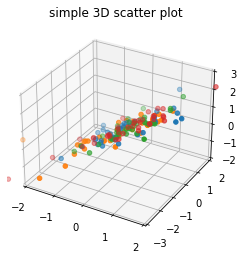

In [24]:
# Visualize data in LDA Space

ax = plt.axes(projection ="3d")
for i in range(4):
    data = test_x_proj[test_y == i, :]
    ax.scatter3D(data[:,0], data[:,1], data[:,0], label=i)
plt.title("simple 3D scatter plot")
#ax.view_init(30,45)
ax.set_zlim([-2,3])
ax.set_ylim([-3,2])
ax.set_xlim([-2,2]) # there are some outliers which make it hard to see the giant clump unless you set axis limits
# But the projected data isnt very easily separable anyways


## Classify with SVM

In [29]:
from sklearn import svm
import sklearn
# The learning is very fast
svm_clf = svm.SVC(C=.1, kernel="poly", degree=2) # best run
# svm_clf = svm.SVC(C=1, kernel="linear")
svm_clf.fit(train_x_proj, train_y)
acc = svm_clf.score(test_x_proj, test_y)
predictions = svm_clf.predict(test_x_proj)
print("Accuracy: ", acc)

Accuracy:  0.3125


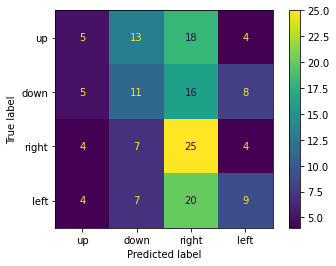

In [30]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_y, predictions,display_labels=['up', 'down', 'right', 'left'])

